In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import preprocess_time_series_v1 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')


In [4]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split_p(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 

def train_test_split_ratio(data, test_split):
	test_len = int(data.shape[0]*test_split)
	return data[:-test_len, :], data[-test_len:, :]


# fit an linear model model and make a one step prediction
def linear_model_forecast(train, testX, forecast_horizon):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	X_train, y_train = train[:, :-forecast_horizon], train[:, -forecast_horizon:]
	#print(forecast_horizon)
	#print(y_train.shape)
	# fit model
	model = MultiOutputRegressor(Ridge())
	model.fit(X_train, y_train)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, forecast_horizon):
	predictions = list()
	# split dataset
	print(data)
	if type(n_test) == int:
		train, test = train_test_split_p(data, n_test)
	else:
		train, test = train_test_split_ratio(data, n_test)

	"""sc = StandardScaler()
	train = sc.fit_transform(train)
	test = sc.transform(test)"""
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		X_test, y_test = test[i, :-forecast_horizon], test[i, -forecast_horizon:]
		#print()
		# fit model on history and make a prediction
		yhat = linear_model_forecast(history, X_test, forecast_horizon)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print(f'>expected={y_test}, predicted={yhat}')
	# estimate prediction error
	error = mean_absolute_error(test[:, -forecast_horizon:], predictions, multioutput='raw_values')
	return error, test[:, -forecast_horizon], predictions, sc


def one_time_linear_model(data, n_test, forecast_horizon):
	predictions = list()
	# split dataset
	print(data)
	if type(n_test) == int:
		train, test = train_test_split_p(data, n_test)
	else:
		train, test = train_test_split_ratio(data, n_test)

	sc = StandardScaler()
	train = sc.fit_transform(train)
	test = sc.transform(test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		X_test, y_test = test[i, :-forecast_horizon], test[i, -forecast_horizon:]
		#print()
		# fit model on history and make a prediction
		yhat = linear_model_forecast(history, X_test, forecast_horizon)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print(f'>expected={y_test}, predicted={yhat}')
	# estimate prediction error
	error = mean_absolute_error(test[:, -forecast_horizon:], predictions, multioutput='raw_values')
	return error, test[:, -forecast_horizon], predictions, sc

#print(df['value'])
#print(type(df['value']))

forecast_horizon = 6
data = series_to_supervised(df['value'].to_list(), 96, forecast_horizon)

#print(data.shape)
mae, y_test, yhat, scaler = walk_forward_validation(data, 0.1, forecast_horizon)

[[24151. 22170. 20691. ... 20784. 20668. 21385.]
 [22170. 20691. 19737. ... 20668. 21385. 23870.]
 [20691. 19737. 19437. ... 21385. 23870. 27943.]
 ...
 [24701. 26974. 27420. ... 29282. 29266. 28022.]
 [26974. 27420. 26472. ... 29266. 28022. 25964.]
 [27420. 26472. 24888. ... 28022. 25964. 24680.]]


NameError: name 'sc' is not defined

[ 0.34529653  0.21379622 -0.22314671 -0.7142363  -1.06513749 -1.37465392]
[ 0.21931735 -0.2081358  -0.69901222 -1.05100761 -1.35972117 -1.58585903]
[-0.0937245  -0.55345    -0.90965236 -1.2261843  -1.4508613  -1.58796911]
[-0.53828388 -0.90014374 -1.21772229 -1.44256931 -1.58043565 -1.62790315]
[-0.99466088 -1.34130384 -1.56278027 -1.69387732 -1.74290539 -1.61555514]
[-1.3597032  -1.59473576 -1.72554276 -1.77254442 -1.64626951 -1.25898964]
[-1.7714175  -1.93527382 -1.97496229 -1.83795687 -1.45157391 -0.93866602]
[-1.88722556 -1.91147018 -1.77612669 -1.39326879 -0.87957046 -0.45379916]
[-1.93414866 -1.80223159 -1.41836024 -0.90336124 -0.47764802 -0.12042574]
[-1.92951614 -1.56865307 -1.04833233 -0.61495998 -0.25830217 -0.03458566]
[-1.66038985 -1.15693698 -0.71980082 -0.35763336 -0.1343664  -0.06931999]
[-1.38358249 -0.97974019 -0.60780713 -0.37160856 -0.30681818 -0.32312898]
[-1.16101444 -0.81473309 -0.57069488 -0.49565734 -0.51208942 -0.46555656]
[-0.72829306 -0.45212638 -0.3799472  -

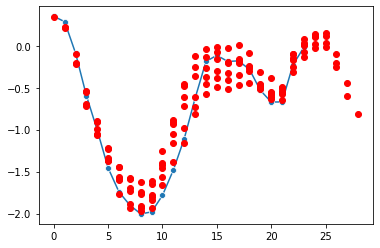

MAE: [0.04951195 0.11056444 0.15856897 0.19592178 0.2118361  0.21515457]


In [5]:
sns.lineplot(
    data=np.array(y_test),style="event",
    markers=True, marker='o'
)

out = 6
init = 0
for y_predict_horizon in yhat:
    plt.plot(np.arange(init, out), np.array(y_predict_horizon), 'ro',
                 label='Predicted Future')
    print(y_predict_horizon)
    init += 1
    out += 1
plt.show()

print("MAE:", mae)

In [33]:
y_test.shape

(3484,)

In [7]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform